### Test a Simple Neural Net for predicting some vdW heterostructure properties

In [222]:
# define target and stacktype.
# target can be changed to other properties -->  Eg, EA, IE, ILD, or Ebind 
TARGET      = 'IE'
STACKTYPE   = 'AUB'

# load dataset
from hetml.data.dataloaders import load_featureset, quickload_datatables

master, targets = quickload_datatables() 
x, y, x_unlb = load_featureset(target=TARGET, stacktype=STACKTYPE) 
x.head() 

returning --> master | targets
returning --> master | targets

Preprocessing Steps:
Feature Space Dim: (6332, 342)
Targets Dim: (790, 37)
	-building Anderson's Rule classes
	-building stacking configuration classes
	-using AUB bilayers, transforming to binary classes
	-dropping feature columns: (6332, 90)
	-dropping metal bilayers: (689, 37)
	-dropping Type III bilayers: (600, 37)
II    310
I     290
Name: band_alignment, dtype: int64
	-dropping bilayers w/ ILD < 2.5: (595, 37)
	-dropping bilayers w/ Eb > 40 meV: (595, 37)
	-dropping bilayers w/ charge transf. > 1 |e|: (595, 37)
	-one-hot-encod band alignment: (6332, 91)

Final --> Feature Space Dim: (6332, 91)
Final --> Targets Dim: (595, 37)

target = 'IE'  stacktype = 'AUB'
x dim: (595, 91)
y dim: (595,)
unlabeled-X dim: (5737, 91)


All Features (Pre-Feature Selection) (p=91):
['avg_gap_nosoc', 'avg_evac', 'avg_hform', 'avg_emass1', 'avg_emass2', 'avg_efermi_hse_nosoc', 'avg_cbm', 'avg_vbm', 'avg_excitonmass1', 'avg_excitonmass2', 

,avg_gap_nosoc,avg_evac,avg_hform,avg_emass1,avg_emass2,avg_efermi_hse_nosoc,avg_cbm,avg_vbm,avg_excitonmass1,avg_excitonmass2,...,PymatgenData mean thermal_conductivity,PymatgenData std_dev thermal_conductivity,PymatgenData minimum melting_point,PymatgenData maximum melting_point,PymatgenData range melting_point,PymatgenData mean melting_point,PymatgenData std_dev melting_point,stacktype,band_alignment_1,band_alignment_2
HUID,,,,,,,,,,,,,,,,,,,,,
huid-9661-AB,2.902748,2.822446,-0.592458,1.331071,0.393551,-4.710007,-3.679410,-6.499765,0.300884,0.298869,...,37.489000,57.401958,265.80,692.68,426.88,423.544000,190.092491,0,1,0
huid-16088-AA,2.277156,2.532932,-0.707300,1.888166,0.811275,-5.037768,-3.812819,-6.096078,1.006116,0.401270,...,61.415798,107.431504,54.80,2041.40,1986.60,629.504000,923.051274,1,0,1
huid-5130-AA,2.775239,3.908084,-0.608220,0.399060,0.398868,-3.997550,-3.549290,-6.139282,0.237370,0.237024,...,49.336300,81.401536,171.60,3695.00,3523.40,1029.366667,1431.402560,1,1,0
huid-722-AA,2.685994,3.236631,-0.772398,0.769459,0.582855,-6.184428,-4.593900,-6.726648,1.027620,1.027473,...,22.152633,42.126097,171.60,600.61,429.01,385.288333,204.570552,1,0,1
huid-9803-AA,1.502788,2.288655,-0.048326,0.354340,0.185149,-4.521174,-3.746575,-5.072145,0.257734,0.256113,...,37.250000,27.620946,302.91,1090.00,787.09,655.162500,336.772002,1,0,1


In [223]:
from pathlib import Path
import torch
import pandas as pd 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# prepare the data
class torchDataset (torch.utils.data.Dataset): 
    def __init__(self, X, y, scale_data=True): 
        if not torch.is_tensor(X) and not torch.is_tensor(y): 
            if scale_data:
                X = StandardScaler().fit_transform(X)
            self.X = torch.from_numpy(X)
            self.y = torch.from_numpy(y.to_numpy() )

    def __len__(self): 
        return len(self.X)
    
    def __getitem__(self, i): 
        return self.X[i], self.y[i]

# get all predictions (semi-supervised ML approach)
datapath = Path('/scratch/user/willhelmd/job/projects/vdw_heterostructures/HetML/models/predict_ild/ILD_predictions.csv') 
df = pd.read_csv(datapath,index_col=0)

# prepare the data 
X = pd.concat((x, x_unlb))
X = X.reindex(df.index)
X = X.reindex(master[master.latmm <= 3.0].index).dropna() 

y = df.y_pred
y = y.reindex(master[master.latmm <= 3.0].index).dropna() 

print(X.shape, y.shape)


(3900, 91) (3900,)


In [224]:
# build a simple feed-foward NN and training/testing functions

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import Module

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class NNet (Module): 
    def __init__(self, input_dim): 
        super(NNet, self).__init__() 

        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64), 
            nn.ReLU(),
            nn.Linear(64,32), 
            nn.ReLU(),
            nn.Linear(32,16), 
            nn.ReLU(),
            nn.Linear(16,8), 
            nn.ReLU(),
            nn.Linear(8,1), 
        )

    def forward(self, X):
        return self.layers(X) 


def train(dataloader, model, verbose=True):
    loss_fn = nn.L1Loss() 
    size = len(dataloader.dataset)
    model.train() 

    for batch, (X, y) in enumerate(dataloader): 
        X, y = X.to(device), y.to(device)
        X, y = X.float(), y.float()

        # compute prediction error
        pred = model(X)
        loss = loss_fn(pred.flatten() , y)
        
        # backprop
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 

        if batch % 30 ==0 and verbose is True: 
            loss, current_batch = loss.item(), batch * len(X)
            print(f'\tloss: {loss:>7f} [{current_batch:>5f}/{size:>5f}]')

def test(dataloader, model):
    loss_fn = nn.L1Loss() 
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            X, y = X.float(), y.float()
            pred = model(X).flatten() 
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Test Error: \n Accuracy: Avg loss: {test_loss:>8f} \n")
    return test_loss
        
def test_predict(dataloader, model): 
    loss_fn = nn.L1Loss() 
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    model.eval()
    test_loss = 0
    Y_true = [] 
    Y_pred = [] 
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            X, y = X.float(), y.float()
            pred = model(X).flatten() 
            test_loss += loss_fn(pred, y).item()

            Y_true = Y_true + y.tolist() 
            Y_pred = Y_pred + pred.tolist() 

    test_loss /= num_batches
    print(f"Test Error: \n Accuracy: Avg loss: {test_loss:>8f} \n")
    return Y_true, Y_pred


In [225]:
from torch.utils.data import DataLoader

BATCH_SIZE  = 30
N_EPOCHS    = 80

# split data
xtrain,xtest, ytrain, ytest = train_test_split(X,y, train_size=0.85, shuffle=True)
xtrain,xval,  ytrain, yval  = train_test_split(xtrain, ytrain, train_size=0.9)

train_loader = DataLoader(torchDataset(xtrain,ytrain), batch_size=BATCH_SIZE, shuffle=True )
vali_loader  = DataLoader(torchDataset(xval,yval), batch_size=BATCH_SIZE, shuffle=True )
test_loader  = DataLoader(torchDataset(xtest, ytest), batch_size=BATCH_SIZE, shuffle=True )

# initialize the model
model = NNet(input_dim=X.shape[1]) 

# Define the loss function and optimizer
loss_fn = nn.L1Loss()  # MAE error
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

res = dict() 
for t in range(N_EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, False)
    loss = test(vali_loader, model)
    res[t] = loss
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: Avg loss: 3.107936 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: Avg loss: 2.299634 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: Avg loss: 0.820248 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: Avg loss: 0.627306 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: Avg loss: 0.505438 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: Avg loss: 0.415824 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: Avg loss: 0.317595 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: Avg loss: 0.285566 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: Avg loss: 0.239899 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: Avg loss: 0.240176 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: Avg loss: 0.217064 

Epoch 12
-------------------------------
Test Error: 
 Accuracy

Test Error: 
 Accuracy: Avg loss: 0.081439 

Test Error: 
 Accuracy: Avg loss: 0.045839 


Test R2:0.92 
Test MAE:0.08 eV


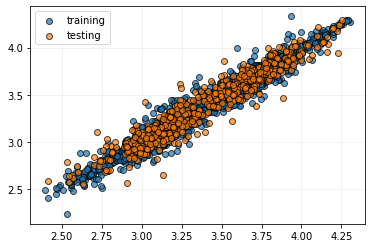

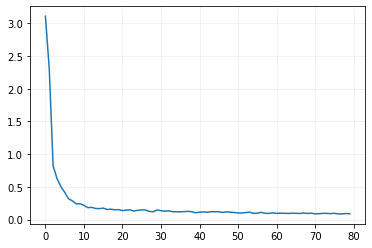

In [226]:
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sb 
import numpy as np 


ytrue_test, ypred_test   = test_predict(test_loader, model)
ytrue_train, ypred_train = test_predict(train_loader, model)

mae = mean_absolute_error(ytrue_test, ypred_test)
r2  = r2_score(ytrue_test, ypred_test)

fig, ax = plt.subplots() 
# sb.kdeplot(ytrue_train, ypred_train, fill=True)
# sb.kdeplot(ytrue_test, ypred_test, fill=True)
ax.scatter(ytrue_train, ypred_train, ec='k', label='training',alpha=0.7)
ax.scatter(ytrue_test, ypred_test, label='testing' , ec='k', c='tab:orange',alpha=0.7)
ax.grid(True, alpha=0.2)
ax.legend() 

fig, ax = plt.subplots() 
ax.plot(res.keys(), res.values() )
ax.grid(True, alpha=0.2)

print(f'\nTest R2:{r2:.2f} \nTest MAE:{mae:.2f} eV')